In [1]:
from bs4 import BeautifulSoup
import email
import pandas as pd
from nltk.tokenize import word_tokenize
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

def extract_text_from_html(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text().strip()

def extract_email_content(email_content):
    msg = email.message_from_string(email_content)
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            content_type = str(part.get_content_type())
            if content_type == "text/plain":
                body += str(part.get_payload())
            elif content_type == "text/html":
                body += extract_text_from_html(str(part.get_payload()))
    else:
        content_type = str(msg.get_content_type())
        if content_type == "text/plain":
            body += str(msg.get_payload())
        elif content_type == "text/html":
            body += extract_text_from_html(str(msg.get_payload()))

    tokens_list = []
    for line in body.split("\n"):
        tokens = word_tokenize(line.strip())
        for token in tokens:
            token = token.lower()
            if token.isalpha():
                tokens_list.append(token)
    content = " ".join(tokens_list)
    return content

def process_file(line):
    label, filename = line.strip().split(" ")
    print("Reading file:", filename)
    with open("../trec07p/data/" + filename, 'r', encoding="ISO-8859-1") as email_file:
        email_content = email_file.read()
        text_content = extract_email_content(email_content)
        email_id = filename.rsplit(".", 1)[-1]
    return email_id, {
        "label": label,
        "content": text_content,
        "file_name": filename
    }

def create_dataframe():
    with open("../trec07p/full/index", 'r') as file_index:
        file_content_dict = {}
        for i, line in enumerate(file_index.readlines()):
            label, filename = line.strip().split(" ")
            print("Reading file:", filename)
            with open("../trec07p/data/" + filename, 'r', encoding="ISO-8859-1") as email_file:
                email_content = email_file.read()
                text_content = extract_email_content(email_content)
                email_id = filename.rsplit(".", 1)[-1]
                file_content_dict[email_id] = {
                    "label": label,
                    "content": text_content,
                    "file_name": filename
                }
    df = pd.DataFrame.from_dict(file_content_dict, orient='index')
    return df

In [31]:
df = create_dataframe()
df.to_csv("spam.csv", index=False)

Reading file: ../data/inmail.1
Reading file: ../data/inmail.2
Reading file: ../data/inmail.3
Reading file: ../data/inmail.4
Reading file: ../data/inmail.5
Reading file: ../data/inmail.6
Reading file: ../data/inmail.7
Reading file: ../data/inmail.8
Reading file: ../data/inmail.9
Reading file: ../data/inmail.10
Reading file: ../data/inmail.11
Reading file: ../data/inmail.12
Reading file: ../data/inmail.13
Reading file: ../data/inmail.14
Reading file: ../data/inmail.15
Reading file: ../data/inmail.16
Reading file: ../data/inmail.17
Reading file: ../data/inmail.18
Reading file: ../data/inmail.19
Reading file: ../data/inmail.20
Reading file: ../data/inmail.21
Reading file: ../data/inmail.22
Reading file: ../data/inmail.23
Reading file: ../data/inmail.24
Reading file: ../data/inmail.25
Reading file: ../data/inmail.26
Reading file: ../data/inmail.27
Reading file: ../data/inmail.28
Reading file: ../data/inmail.29
Reading file: ../data/inmail.30
Reading file: ../data/inmail.31
Reading file: ../

/Users/mariaanson/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Reading file: ../data/inmail.61110
Reading file: ../data/inmail.61111
Reading file: ../data/inmail.61112
Reading file: ../data/inmail.61113
Reading file: ../data/inmail.61114
Reading file: ../data/inmail.61115
Reading file: ../data/inmail.61116
Reading file: ../data/inmail.61117
Reading file: ../data/inmail.61118
Reading file: ../data/inmail.61119
Reading file: ../data/inmail.61120
Reading file: ../data/inmail.61121
Reading file: ../data/inmail.61122
Reading file: ../data/inmail.61123
Reading file: ../data/inmail.61124
Reading file: ../data/inmail.61125
Reading file: ../data/inmail.61126
Reading file: ../data/inmail.61127
Reading file: ../data/inmail.61128
Reading file: ../data/inmail.61129
Reading file: ../data/inmail.61130
Reading file: ../data/inmail.61131
Reading file: ../data/inmail.61132
Reading file: ../data/inmail.61133
Reading file: ../data/inmail.61134
Reading file: ../data/inmail.61135
Reading file: ../data/inmail.61136
Reading file: ../data/inmail.61137
Reading file: ../dat

,label,content,file_name
0,1,do you feel the pressure to perform and not ri...,../data/inmail.1
1,0,hi i just updated from the gulus and i check o...,../data/inmail.2
2,1,mega authenticv i a g r a discount pricec i a ...,../data/inmail.3
3,1,hey billy it was really fun going out the othe...,../data/inmail.4
4,1,system of the home it will have the capabiliti...,../data/inmail.5


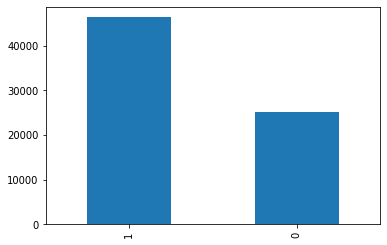

In [2]:
df = pd.read_csv("spam.csv", index_col=False)

# Filter out emails with no content that has less then 2 words
df = df.loc[df['content'].str.split().str.len() > 2]

# Change spam and ham to 1 and 0
df['label'] = df['label'].apply(lambda x: 1 if x == "spam" else 0)
df['label'].value_counts().plot(kind='bar')

df.head()

In [3]:
# train test split with x and y
from sklearn.model_selection import train_test_split

X = df['content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

spam_words_trial_a = ["free" , "win", "porn", "click here", "money", "urgent", "exclusive", "easy", "income", "opportunity", "loan", "quick"]

file = open("spam_words.txt", "r")
spam_words_trial_b = set(file.read().splitlines())
print(spam_words_trial_b)

{'spam', 'viagra', 'malware', 'act now', 'extra', 'click here', 'double', 'order', 'lose', 'compare', 'affordable', 'fast cash', 'success', '100% free', 'credit', 'meet singles', 'free', 'virus', 'price', 'limited', 'hidden', 'valium', '$$$', 'check', 'shopper', 'performance', 'profit', 'now', 'loans', 'sales', 'trial', 'bonus', 'join', 'home', 'remove', 'win', 'click', 'lower interest rate', 'legal', 'clearance', 'celebrity', 'miracle', 'ad', 'freedom', 'medicine', 'deal', 'instant', 'luxury', 'diagnostics', 'refinance', 'money', 'million dollars', 'visit our website', 'cash', 'fast', 'lose weight', 'incredible deal', 'no credit check', 'unsolicited', 'only', 'buy', 'subscribe', '$discount', 'million', 'collect', 'prize', 'earn', 'chance'}


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

import numpy as np


def trial_run_with_ml_models(spam_words, X_train, y_train, X_test, y_test, test_filenames, n_gram_range=None):
    if spam_words is not None:
        vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.995, vocabulary=spam_words)
    else:
        vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.995)

    if n_gram_range is not None:
        vectorizer.set_params(ngram_range=n_gram_range)

    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)

    lr = LogisticRegression(penalty='l1', solver='liblinear')
    lr.fit(x_train, y_train)
    res = lr.predict_proba(x_test)[:, 1]
    print("Score for logistic regression is:", roc_auc_score(np.array(y_test), res))
    print(classification_report(y_test, lr.predict(x_test)))
    sort_indices = np.argsort(res)[::-1]
    print("\tTop 10 spam docs for logistic regression are: ", test_filenames[sort_indices[:10]].values.tolist())

    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    res = dt.predict_proba(x_test)[:, 1]
    print("Score for decision tree is:", roc_auc_score(np.array(y_test), res))
    print(classification_report(y_test, lr.predict(x_test)))
    sort_indices = np.argsort(res)[::-1]
    print("\tTop 10 spam docs for decision tree are: ", test_filenames[sort_indices[:10]].values.tolist())

    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    res = nb.predict_proba(x_test)[:, 1]
    print("Score for naive bayes is:", roc_auc_score(np.array(y_test), res))
    print(classification_report(y_test, lr.predict(x_test)))
    sort_indices = np.argsort(res)[::-1]
    print("\tTop 10 spam docs for naive bayes are: ", test_filenames[sort_indices[:10]].values.tolist())

print("*"*50 + " Part 1 : Trial A " + "*"*50)
trial_run_with_ml_models(spam_words_trial_a, X_train, y_train, X_test, y_test, X_test.index)

print("*"*50 + " Part 1 : Trial B " + "*"*50)
trial_run_with_ml_models(spam_words_trial_b, X_train, y_train, X_test, y_test, X_test.index)

print("*"*50 + " Part 2 : Unigram " + "*"*50)
trial_run_with_ml_models(None, X_train, y_train, X_test, y_test, X_test.index)

print("*"*50 + " Extra Credit : Bigram " + "*"*50)
trial_run_with_ml_models(None, X_train, y_train, X_test, y_test, X_test.index, n_gram_range=(2, 2))



************************************************** Part 1 : Trial A **************************************************
Score for logistic regression is: 0.6167964839198701
              precision    recall  f1-score   support

           0       0.51      0.01      0.02      5039
           1       0.65      1.00      0.79      9271

    accuracy                           0.65     14310
   macro avg       0.58      0.50      0.40     14310
weighted avg       0.60      0.65      0.51     14310

	Top 10 spam docs for logistic regression are:  [46096, 13628, 75309, 52106, 46854, 40876, 63965, 32640, 25145, 9552]
Score for decision tree is: 0.6477638586857695
              precision    recall  f1-score   support

           0       0.51      0.01      0.02      5039
           1       0.65      1.00      0.79      9271

    accuracy                           0.65     14310
   macro avg       0.58      0.50      0.40     14310
weighted avg       0.60      0.65      0.51     14310

	Top 10 s

In [5]:
# Get the entries in index [46096, 13628, 75309, 52106, 46854, 40876, 63965, 32640, 25145, 9552] from df

df.loc[[14159, 32012, 19268, 42105, 30449, 62535, 3872, 28878, 60830, 70143]]

,label,content,file_name
14159,1,online casinos are known for giving generous w...,../data/inmail.14160
32012,1,fda approved here chose your product and site ...,../data/inmail.32013
19268,1,all of your favorite are available with fast d...,../data/inmail.19269
42105,1,viagraif you have a problem getting or keeping...,../data/inmail.42106
30449,1,dear valued member i wanted to advise you on w...,../data/inmail.30450
62535,1,oem software means no no packing case no bookl...,../data/inmail.62536
3872,1,help for every person all over the whole world...,../data/inmail.3873
28878,1,mouvement desjardins cher e membre accèsd le d...,../data/inmail.28879
60830,1,seize the opportunity anatrim the newest most ...,../data/inmail.60831
70143,1,oem software means no no packing case no bookl...,../data/inmail.70144
